# Data Overview

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style="whitegrid")

In [182]:
log_dir = Path('../../results/logs/raw-metadata')

In [183]:
def load_ftp_paths(log_dir, category):
    # Get the path to the txt file
    txt_file_path = list(log_dir.glob(f"./{category}_ftp_paths.txt"))
    
    # Ensure there's exactly one matching file
    if not txt_file_path:
        raise FileNotFoundError("No matching txt file found.")
    elif len(txt_file_path) > 1:
        raise ValueError("Multiple matching txt files found.")
    
    # Read the txt file into a DataFrame
    df = pd.read_csv(txt_file_path[0], header=None, names=["path"])  
    return df

In [184]:
categories = ['bacteria', 'fungi', 'viral', 'archaea', 'protozoa']

In [185]:
ftp_files = {category: load_ftp_paths(log_dir, category) for category in categories}

In [186]:
for category in categories:
    print(f'{category}: {ftp_files[category].count()}')

bacteria: path    267630
dtype: int64
fungi: path    9762
dtype: int64
viral: path    154164
dtype: int64
archaea: path    5883
dtype: int64
protozoa: path    1278
dtype: int64


In [187]:
def load_assembly_summary(file_path: Path, category: str) -> pd.DataFrame:
    """
    Load a NCBI assembly_summary.txt file, handling comment lines and headers.
    """
    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found.")
    
    # Extract the header from the comment line
    with open(file_path) as f:
        for line in f:
            if line.startswith("#assembly_accession"):
                header = line.strip("#").strip().split("\t")
                break

    # Now read the file with no header, skipping all comment lines
    df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=header, low_memory=False)
    df['category'] = category

    # Convert release date column if present
    if 'seq_rel_date' in df.columns:
        df['seq_rel_date'] = pd.to_datetime(df['seq_rel_date'], errors='coerce')

    return df

In [188]:
def load_all_summaries(metadata_dir: Path, categories: list) -> pd.DataFrame:
    dfs = []
    for category in categories:
        file_path = metadata_dir / f"{category}_assembly_summary.txt"
        try:
            df = load_assembly_summary(file_path, category)
            dfs.append(df)
        except FileNotFoundError:
            print(f"[WARNING] Missing: {file_path.name}")
    if not dfs:
        raise ValueError("No valid files loaded.")
    return pd.concat(dfs, ignore_index=True)

In [189]:
def summarize_assembly_levels(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby(['category', 'assembly_level']).size().unstack(fill_value=0)

In [190]:
import matplotlib.patches as mpatches

def plot_submissions_over_time(df, output_path: Path = None, cutoff_year: int = None):
    df = df.dropna(subset=['seq_rel_date']).copy()
    df['year'] = df['seq_rel_date'].dt.year

    plt.figure(figsize=(10, 6))

    # Define consistent palette
    palette = sns.color_palette("Set2", n_colors=df['category'].nunique())
    categories = sorted(df['category'].unique())
    category_palette = dict(zip(categories, palette))

    # Plot each category individually to preserve legend control
    for category in categories:
        sub_df = df[df['category'] == category]
        sns.histplot(sub_df, x='year', bins=30, color=category_palette[category], label=category, element='bars', stat='count', binrange=(df['year'].min(), df['year'].max()))

    plt.title("Genome Assembly Submissions Over Time by Category")
    plt.xlabel("Year")
    plt.ylabel("Number of Assemblies")

    # Add cutoff line and legend
    if cutoff_year:
        plt.axvline(cutoff_year, color='red', linestyle='--', label=f"Cutoff: {cutoff_year}")

    plt.legend(title="Category", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()
    plt.close()

In [191]:
def plot_genome_size_distribution(df, output_path):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df[df['genome_size'] < 1e8], x='category', y='genome_size', density_norm='width', inner='quartile')
    plt.title("Genome Size Distribution by Category")
    plt.ylabel("Genome Size (bp)")
    plt.xlabel("Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()

In [192]:
def plot_gc_content_distribution(df, output_path):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df.dropna(subset=['gc_percent']), x='gc_percent', hue='category', fill=True, common_norm=False, alpha=0.5)
    plt.title("GC Content Distribution by Category")
    plt.xlabel("GC Content (%)")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()

In [193]:
def plot_gc_content_per_category(df: pd.DataFrame, output_path: Path):
    for cat in df['category'].unique():
        sub = df[df['category'] == cat].copy()

        plt.figure(figsize=(6, 5))
        sns.kdeplot(data=sub.dropna(subset=['gc_percent']), x='gc_percent', fill=True, color='purple', alpha=0.5)
        plt.title(f"{cat.capitalize()} GC Content Distribution")
        plt.xlabel("GC Content (%)")
        plt.tight_layout()
        plt.savefig(output_path / f"{cat}_gc_content.pdf")
        plt.show()
        plt.close()

In [194]:
from datetime import datetime

def run_metadata_analysis(metadata_dir: Path, output_path: Path):
    categories = ["bacteria", "archaea", "viral", "protozoa"]
    cutoff_date = datetime(2023, 4, 1)

    print("[INFO] Loading metadata...")
    df = load_all_summaries(metadata_dir, categories)

    # Filter by release date
    df = df[df['seq_rel_date'] < cutoff_date]
    print(f"[INFO] Filtered dataset to {len(df)} assemblies released before {cutoff_date.date()}.")

    print("[INFO] Summarizing assembly levels...")
    summary = summarize_assembly_levels(df)
    print(summary)

    print("[INFO] Plotting submission trends...")
    plot_submissions_over_time(df, output_path / "assembly_submission_trend.pdf", cutoff_year=cutoff_date.year)

    print("[INFO] Plotting genome size distribution...")
    plot_genome_size_distribution(df, output_path / "genome_size_distribution.pdf")

    print("[INFO] Plotting GC content distribution...")
    plot_gc_content_distribution(df, output_path / "gc_content_distribution.pdf")
    
    print("[INFO] Plotting GC content distribution per category...")
    plot_gc_content_per_category(df, output_path)

    return df, summary

[INFO] Loading metadata...
[INFO] Filtered dataset to 1732581 assemblies released before 2023-04-01.
[INFO] Summarizing assembly levels...
assembly_level  Chromosome  Complete Genome   Contig  Scaffold
category                                                      
archaea                 86              592     8408      5205
bacteria              6193            38384  1284758    222689
protozoa               184               22      562      1072
viral                 6927           147135    10315        49
[INFO] Plotting submission trends...


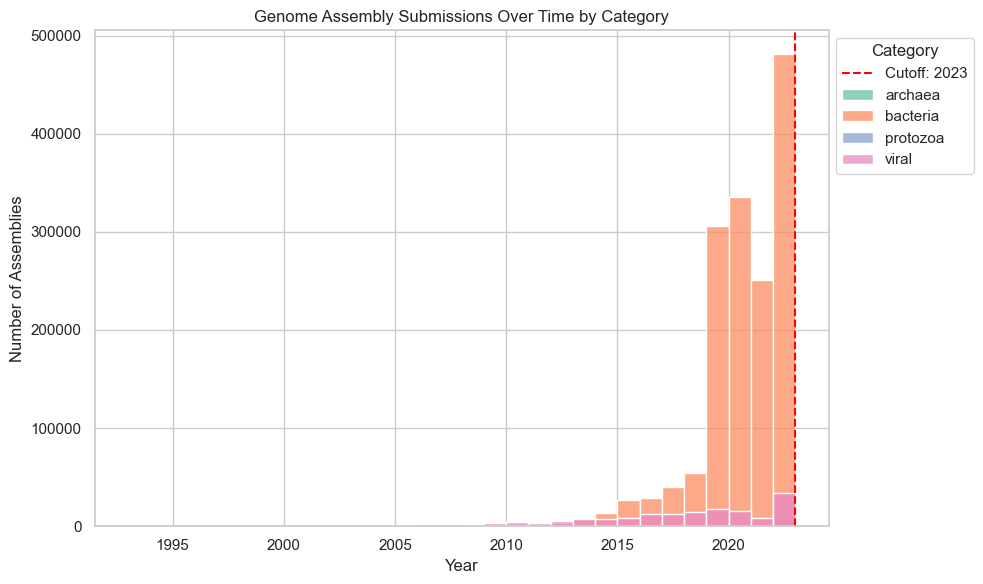

[INFO] Plotting genome size distribution...


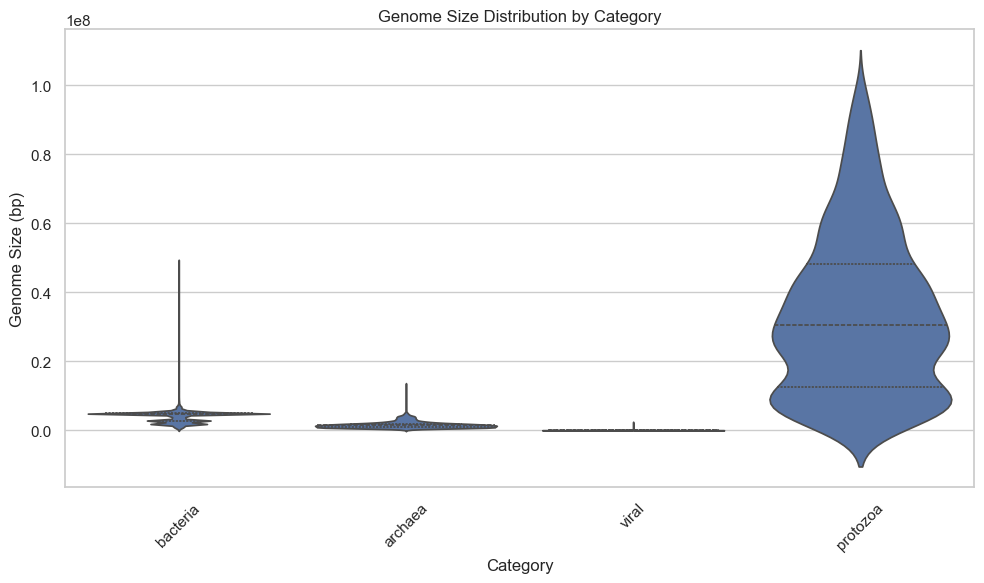

[INFO] Plotting GC content distribution...


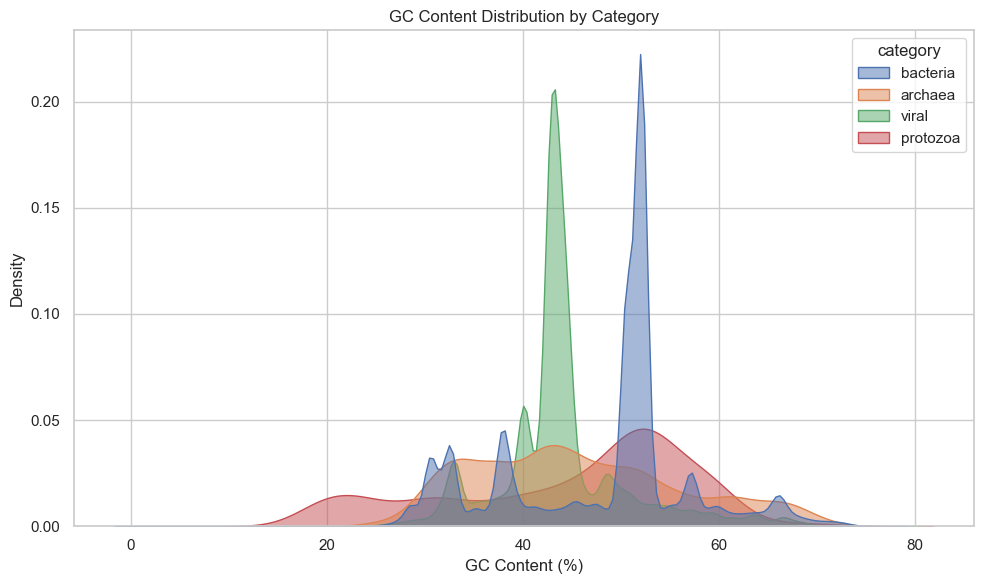

[INFO] Plotting GC content distribution per category...


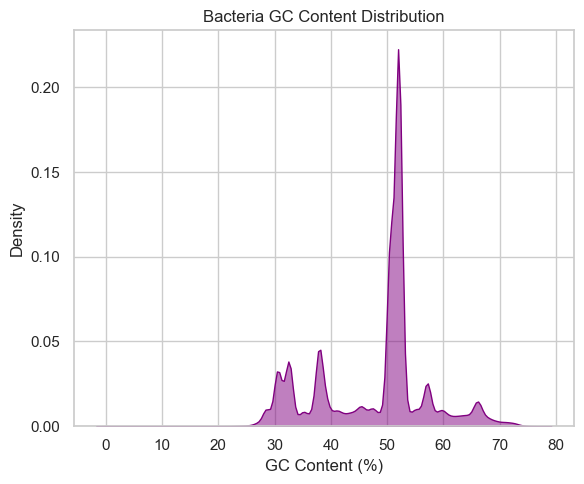

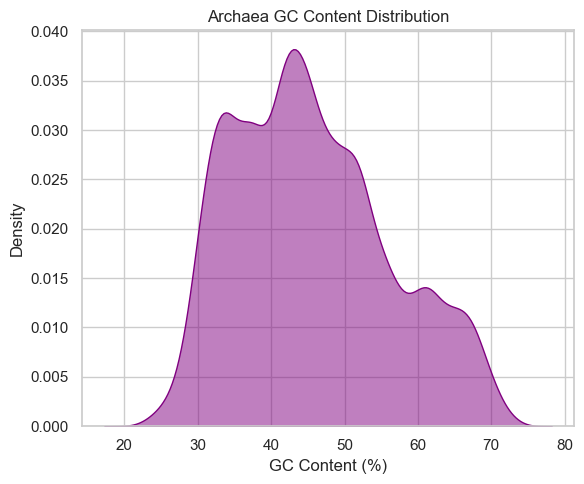

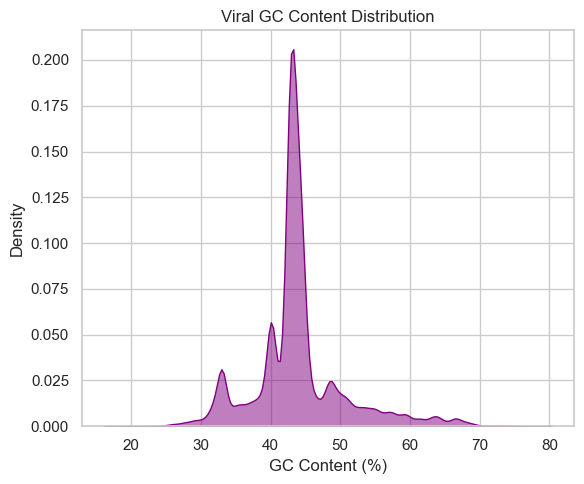

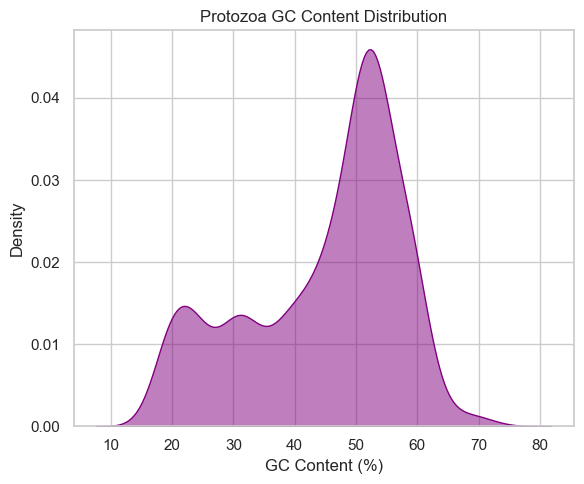

In [195]:
output_path = Path('../../figures')
df, summary = run_metadata_analysis(log_dir, output_path)